c:\Users\rama\Desktop\illinois\deeplearning\cs577-s19-anantanarayanan-iyengar\AS1\src

In get_config_value()
Model file is  spam_nn.json

In get_config_value()
Model weights file is  spam_model.h5

In get_config_value()
Retrain model is  True

Opened model file

Loading weights

Loaded model successfully from saved model and weights

Retraining model

In build_and_train_model


*** Layer 1 output size 32
Layer 2 output size 16
Layer 3 output size 2
*** Dropout1 0.200000
*** Dropout2 0.000000
Optimizer being used is optimizers.Adam(lr=0.001)

Train on 2311 samples, validate on 1139 samples
Epoch 1/25
2311/2311 [==============================] - 1s 268us/step - loss: 0.6630 - acc: 0.6162 - val_loss: 0.5725 - val_acc: 0.7322

Epoch 00001: val_acc improved from -inf to 0.73222, saving model to checkpoints\weights-improvement-01-0.73.hdf5
Epoch 2/25
2311/2311 [===========

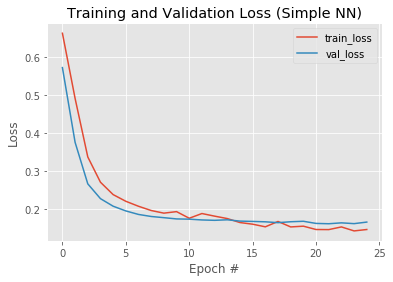

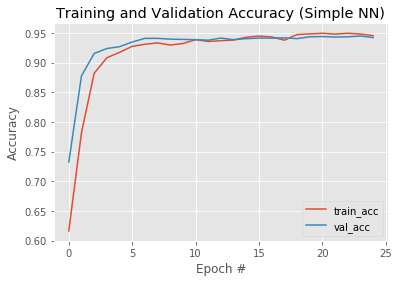


In build_and_train_model


*** Layer 1 output size 32
Layer 2 output size 16
Layer 3 output size 2
*** Dropout1 0.200000
*** Dropout2 0.000000
Optimizer being used is optimizers.SGD(lr=0.001)

Train on 2311 samples, validate on 1139 samples
Epoch 1/25
2311/2311 [==============================] - 0s 194us/step - loss: 1.0246 - acc: 0.3981 - val_loss: 0.9180 - val_acc: 0.4113

Epoch 00001: val_acc improved from -inf to 0.41133, saving model to checkpoints\weights-improvement-01-0.41.hdf5
Epoch 2/25
2311/2311 [==============================] - 0s 43us/step - loss: 0.9772 - acc: 0.4091 - val_loss: 0.8827 - val_acc: 0.4162

Epoch 00002: val_acc improved from 0.41133 to 0.41615, saving model to checkpoints\weights-improvement-02-0.42.hdf5
Epoch 3/25
2311

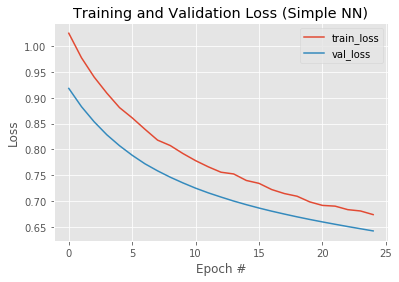

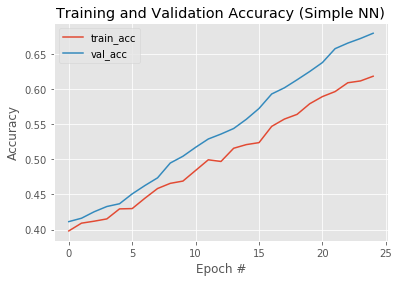


Validation accuracy for Adam is greater than SGD. Sticking with Adam
345
(345, 57)
(345, 2)

Generating optimizers list for tuning hyperparameters

optimizer_name
optimizers.Adam(lr=0.001)
optimizer_name
optimizers.Adam(lr=0.0001)
Done


*** Running GridSearchCV to tune hyperparameters.

*** After GridSearchCV


 *** Before GridSearch fit


*** Layer 1 output size 32
Layer 2 output size 16
Layer 3 output size 2
*** Dropout1 0.000000
*** Dropout2 0.000000
Optimizer being used is optimizers.Adam(lr=0.001)


*** Layer 1 output size 32
Layer 2 output size 16
Layer 3 output size 2
*** Dropout1 0.000000
*** Dropout2 0.000000
Optimizer being used is optimizers.Adam(lr=0.001)


*** Layer 1 output size 32
Layer 2 output size 16
Layer 3 output size 2
*** Dropout1 0.000000
*** Dropout2 0.000000
Optimizer being used is optimizers.Adam(lr=0.001)


*** Layer 1 output size 32
Layer 2 output size 16
Layer 3 output size 2
*** Dropout1 0.000000
*** Dropout2 0.000000
Optimizer being used is optimizers.A

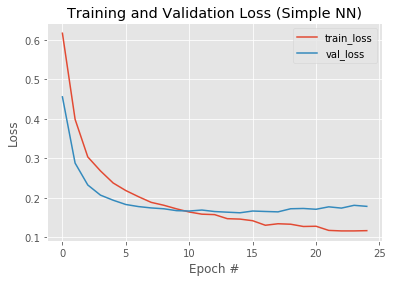

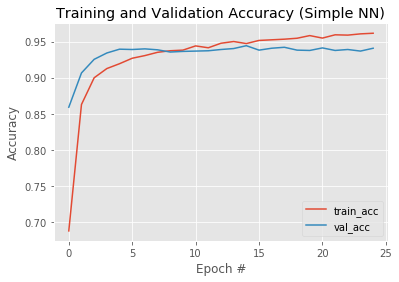


[INFO] evaluating network...
             precision    recall  f1-score   support

       spam       0.95      0.95      0.95       700
        ham       0.92      0.92      0.92       450

avg / total       0.94      0.94      0.94      1150



In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import configparser
import csv
from keras.utils import np_utils
from keras import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout
from keras.layers.core import Dense
from keras.models import model_from_json
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
import numpy as np
from numpy.random import RandomState
from matplotlib import pyplot as plt
import random
import urllib
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.misc import toimage
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

def load_spam_data(split_percentage = 0.25,):
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
    response = urllib.request.urlopen(url)
    #data = response.read()
   
    #data = []
    # Read the csv fle.
    #file = open("C:\\Users\\rama\\Desktop\\illinois\\deeplearning\\cs577-s19-anantanarayanan-iyengar\\AS1\\data\\spambase.data")
   
    data = []
    reader = csv.reader(response.read().decode('utf-8').splitlines())
    next(reader, None)
    for row in reader:
        data.append(row)
    #file.close()
    
    X = np.array([x[:-1] for x in data]).astype(np.float)
    Y = np.array([x[-1] for x in data]).astype(np.float)
    
    # normalize the data by subtracting each column from its mean and dividing by the std deviation.
    X = StandardScaler().fit_transform(X)
    
    Y = np_utils.to_categorical(Y)
    return train_test_split(X, Y, test_size=split_percentage, random_state=RandomState())

# https://stackoverflow.com/questions/5055042/whats-the-best-practice-using-a-settings-file-in-python
def get_config_value(config_file, section_name, option_name):
    print("\nIn get_config_value()")

    config = configparser.ConfigParser()
    
    try:
        with open(config_file) as f:
            config.read_file(f)
            return config.get(section_name, option_name)
    except IOError:
        print("Error occurred while reading config file ", config_file)

def plot(epochs, title, fit, ylabel, xlabel, y_param1, y_param2, y_label1, y_label2):
    N = np.arange(0, epochs)
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, fit.history[y_param1], label=y_label1)
    plt.plot(N, fit.history[y_param2], label=y_label2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()    

def tune_hyperparameters(X_train, Y_train, def_optimizer, datasize, proportion_to_use = 0.1):
    records_to_use = int(X_train.shape[0] * proportion_to_use)
    print(records_to_use)
    
    filtered_X_train = X_train[0:records_to_use, ]
    print(filtered_X_train.shape)
    
    filtered_Y_train = Y_train[0:records_to_use,]
    print(filtered_Y_train.shape)
    
    keras_model = KerasClassifier(build_fn = create_model, epochs = 40, batch_size = 32, 
                                  dropout1=0.2, dropout2 = 0, layer_1_output_size = 32, verbose = 0)

    #optimizer = ['SGD', 'RMSprop', 'Adam']
    learning_rate = [0.001, 0.0001]
    layer_1_output_sizes = [32, int(datasize / 2)]
    epochs = [25, 50]
    dropouts1 = [0, 0.2]
    dropouts2 = [0, 0.2]
    
    print("\nGenerating optimizers list for tuning hyperparameters\n")
    optimizers_with_rates = []
    for j in range(0, len(learning_rate)):
        optimizer_name = def_optimizer + "(" + "lr=" + str(learning_rate[j]) + ")"
        print("optimizer_name")
        print(optimizer_name)
        optimizers_with_rates.append(optimizer_name)
    print("Done\n")       

    print("\n*** Running GridSearchCV to tune hyperparameters.")
    param_grid = dict(epochs=epochs, optimizer_to_use=optimizers_with_rates, dropout1=dropouts1, dropout2 = dropouts2,
                     layer_1_output_size = layer_1_output_sizes)
    grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, n_jobs=1)
    print("\n*** After GridSearchCV\n")

    print("\n *** Before GridSearch fit\n")
    grid_result = grid.fit(X_train, Y_train)
    print("\n *** After GridSearch fit\n")

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return grid_result.best_params_
        
def create_model(optimizer_to_use = 'optimizers.SGD(lr=0.01)', dropout1 = 0.2,
                 dropout2 = 0, layer_1_output_size = 32, activation1 = 'relu', 
                 activation2 = 'relu', activation3 = 'softmax', 
                 loss_function = 'binary_crossentropy', data_size = 57):
    layer_2_output_size = int(layer_1_output_size / 2)
    output_size = 2
    
    print("\n*** Layer 1 output size %d" % layer_1_output_size)
    print("Layer 2 output size %d" % layer_2_output_size)
    print("Layer 3 output size %d" % output_size)
    print("*** Dropout1 %f" % dropout1)
    print("*** Dropout2 %f" % dropout2)
    print("Optimizer being used is %s\n" % optimizer_to_use)
    
    model = models.Sequential()
    model.add(Dense(layer_1_output_size, input_dim = data_size, activation = 'relu'))
    model.add(Dropout(dropout1))
    # Map the k dimensions from the previous layer to 2 dimensions to try and learn a linear activation
    # function.
    #model.add(Dense(2, activation='linear'))
    model.add(Dense(layer_2_output_size, activation = 'relu'))
    model.add(Dropout(dropout2))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer = eval(optimizer_to_use), metrics=['acc'])
    return model

def build_and_train_model(X_train, Y_train, epochs, dropout1, dropout2, optimizer):
    print("\nIn build_and_train_model\n")
    model = create_model(optimizer, dropout1, dropout2)
    
    if not os.path.exists("checkpoints"):
        print("Creating checkpoints directory")
        os.makedirs("checkpoints")

    best_model = os.path.join("checkpoints", "weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5")
    checkpoint = ModelCheckpoint(best_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    fit = model.fit(X_train, Y_train,
                    validation_split = 0.33,
                    epochs = epochs, batch_size = 32, callbacks=callbacks_list)

    # plot the training loss and accuracy
    plot(epochs, "Training and Validation Loss (Simple NN)", fit, "Loss", "Epoch #", "loss", "val_loss", "train_loss", "val_loss")
    plot(epochs, "Training and Validation Accuracy (Simple NN)", fit, "Accuracy", "Epoch #", "acc", "val_acc", "train_acc", "val_acc")
    return model, fit

# https://machinelearningmastery.com/save-load-keras-deep-learning-models/    
def save_model(model, model_file, weights_file):
    model_json = model.to_json()
    
    with open(model_file, "w") as json_file:
        json_file.write(model_json)
        
    model.save_weights(weights_file)
    
# https://machinelearningmastery.com/save-load-keras-deep-learning-models/    
def load_model(model_file, weights_file):
    try:
        json_file = open(model_file, 'r')
        print("\nOpened model file")
        loaded_model_json = json_file.read()

        json_file.close()

        loaded_model = model_from_json(loaded_model_json)
        
        print("\nLoading weights")
        # load weights into new model
        loaded_model.load_weights(weights_file)
        return loaded_model

    except IOError:
        print("Error occurred while reading model file", model_file)
        return None
    
def test_model(model, X_test, Y_test):
    print("\n[INFO] evaluating network...")
    classes = np.array(["spam", "ham"])
    predictions = model.predict(X_test, batch_size=32)
    print(classification_report(Y_test.argmax(axis=1),
        predictions.argmax(axis=1), target_names=classes))

# The main function for the program.    
def main():
    print(os.getcwd())

    X_train, X_test, Y_train, Y_test = load_spam_data()
    data_size = X_train.shape[1]

    model_file = get_config_value("AS1.ini", "Task 2", "modelFile")

    print("Model file is ", model_file)

    weights_file = get_config_value("AS1.ini", "Task 2", "modelWeightsFile")
    print("Model weights file is ", weights_file)

    retrain_model = get_config_value("AS1.ini", "Task 2", "retrain_model")
    print("Retrain model is ", retrain_model)

    loaded_model = load_model(model_file, weights_file)
    if (loaded_model is not None):
        print("\nLoaded model successfully from saved model and weights")
    else:
        print("\nNo saved model found on disk")

    if (retrain_model == "True"):
        print("\nRetraining model")
    else:
        if (loaded_model is not None):
            print("\nNot Retraining model")
            return test_model(loaded_model, X_test, Y_test)

    def_epochs = 25
    def_optimizer = 'optimizers.Adam(lr=0.001)'
    def_dropout1 = 0.2
    def_dropout2 = 0

    adam_default_model, fit_adam = build_and_train_model(X_train, Y_train, def_epochs, def_dropout1, def_dropout2, 
                                                         def_optimizer)

    sgd_default_model, fit_sgd = build_and_train_model(X_train, Y_train, def_epochs, def_dropout1, def_dropout2, 
                                                       "optimizers.SGD(lr=0.001)")

    def_optimizer = "optimizers.Adam"
    if (fit_adam.history["val_acc"] < fit_sgd.history["val_acc"]):
        print("\nValidation accuracy for SGD [%f] is greater than Adam [%f]. Going with SGD" % fit_adam.history["val_acc"],
              fit_sgd.history["val_acc"])
        def_optimizer = "optimizers.SGD"
    else:
        print("\nValidation accuracy for Adam is greater than SGD. Sticking with Adam")

    best_params = tune_hyperparameters(X_train, Y_train, def_optimizer, data_size)
    print("\nBest hyperparameters returned by tuning are ")
    print(best_params)

    tuned_dropout1 = best_params['dropout1']
    tuned_dropout2 = best_params['dropout2']
    tuned_optimizer = best_params['optimizer_to_use']
    tuned_epochs = best_params['epochs']

    tuned_model,fit = build_and_train_model(X_train, Y_train, tuned_epochs, tuned_dropout1, tuned_dropout2, tuned_optimizer)

    test_model(tuned_model, X_test, Y_test)
    save_model(tuned_model, model_file, weights_file)
    
main()    
